In [1]:
import torch 
import meep as mp
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image

print("Cuda Device Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Device Current:", torch.cuda.current_device())

Cuda Device Available: True
Device Count: 1
Device Current: 0


### Utilities

In [2]:
class SpectralConv2d(nn.Module):
    """2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
    """
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)

        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x
    
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x
    

In [3]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

### FNOv1

In [ ]:
class AntennaImageDataset(Dataset): 
    def __init__(self, folder_path): 
        self.label_path = os.path.join(folder_path, 'labels')
        self.input_path = os.path.join(folder_path, 'x')
        self.len = None
        
    def __len__(self): 
        if self.len == None: 
            self.len = 0
            for name in os.listdir(self.label_path):
                if ".png" in name: 
                    self.len += 1
        return self.len
        
    def __getitem__(self, idx): 
        input_path = os.path.join(self.input_path, 'train_%04d.png' % idx)
        label_path = os.path.join(self.label_path, 'train_%04d_label.png' % idx)
        
        input_img = read_image(input_path).to(dtype=torch.float32) / 255
        label_img = read_image(label_path).to(dtype=torch.float32) / 255
        
        return input_img, label_img

In [ ]:
datasets = AntennaImageDataset('./data')
demo_input, demo_label = datasets[10]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(demo_input.permute(1, 2, 0))
axes[1].imshow(demo_label.permute(1, 2, 0))

In [ ]:
train_datasets, test_datasets = random_split(datasets, [0.8, 0.2])
train_dataloader = DataLoader(train_datasets, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=32, shuffle=True)

In [ ]:
class FNO2d(nn.Module): 
    def __init__(self, modes1, modes2, width): 
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9
        
        self.p = nn.Linear(3, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4)
        
    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = self.p(x.permute(0, 2, 3, 1))
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = self.q(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

In [ ]:
model = FNO2d(32, 32, 64) 
loss_func = LpLoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_plot = []
test_plot = []

pbar = range(1000)
for epoch in pbar: 
    print("Beginning Epoch %d" % epoch)
    model.train()
    train_loss = 0
    test_loss = 0
    
    for i, (x, label) in enumerate(iter(train_dataloader)):
        print("  optimizing batch %d" % i)
        
        bsz = x.shape[0]
        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(output.view(bsz, -1),
                          label.view(bsz, -1))
        loss.backward()
        optimizer.step()
        
        print("    loss = %f" % loss.item())
        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad(): 
        for x, label in iter(test_dataloader): 
            bsz = x.shape[0]
            output = model(x)
            loss = loss_func(output.view(bsz, -1),
                              label.view(bsz, -1))
            test_loss += loss.item()
        
    # pbar.set_postfix({"train_loss": train_loss, 
    #                   "test_loss": test_loss})
    
    print("===\nEpoch %d Results: " % epoch)
    print("  train_loss = %f" % train_loss)
    print("  test_loss = %f" % test_loss)
    
    train_plot.append(train_loss)
    test_plot.append(test_loss)
    

Beginning Epoch 0
  optimizing batch 0
    loss = 27.969021
  optimizing batch 1
    loss = 33.712822
  optimizing batch 2
    loss = 22.552387
  optimizing batch 3
    loss = 20.647734
  optimizing batch 4
    loss = 19.875811
  optimizing batch 5
    loss = 19.030844
  optimizing batch 6
    loss = 20.582521
  optimizing batch 7
    loss = 22.070118
  optimizing batch 8
    loss = 21.513411
  optimizing batch 9
    loss = 20.677086
  optimizing batch 10
    loss = 10.093281
===
Epoch 0 Results: 
  train_loss = 238.725035
  test_loss = 51.298786
Beginning Epoch 1
  optimizing batch 0
    loss = 19.271246
  optimizing batch 1
    loss = 18.051876
  optimizing batch 2
    loss = 17.740082
  optimizing batch 3
    loss = 17.219385
  optimizing batch 4
    loss = 16.718529
  optimizing batch 5
    loss = 17.190046
  optimizing batch 6
    loss = 17.458103
  optimizing batch 7
    loss = 16.495523
  optimizing batch 8
    loss = 16.160934
  optimizing batch 9
    loss = 16.009195
  optimiz

KeyboardInterrupt: 

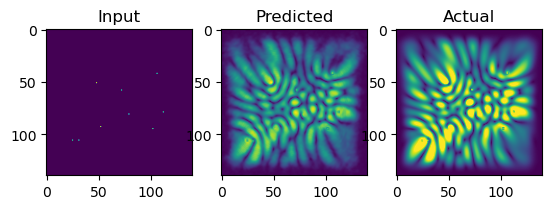

In [ ]:
# torch.save(model.state_dict(), "checkpoints/fno2d-jic.pt")

def gaussian_normalize(x): 
    mean = torch.mean(x)
    std = torch.std(x)
    eps = 0.00001
    return (x - mean) / (std + eps)

with torch.no_grad(): 
    demo_x, demo_label = test_datasets[22]
    demo_y = model(demo_x[None, ...]).squeeze(0)
    demo_label = gaussian_normalize(demo_label)
    demo_y = gaussian_normalize(demo_y)
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(demo_x.permute(1, 2, 0))
    axes[1].imshow(demo_y.permute(1, 2, 0))
    axes[2].imshow(demo_label.permute(1, 2, 0))
    axes[0].set_title("Input")
    axes[1].set_title("Predicted")
    axes[2].set_title("Actual")

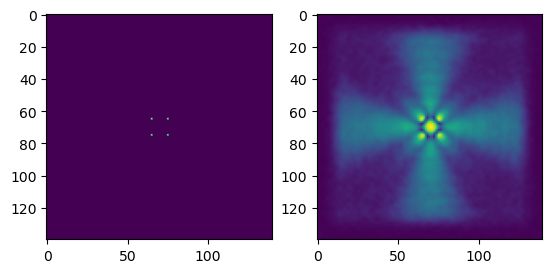

In [ ]:
with torch.no_grad(): 
    x = np.zeros((1, 140, 140, 1))
    x[:, 65, 65, :] = 1
    x[:, 75, 75, :] = 1
    x[:, 65, 75, :] = 1
    x[:, 75, 65, :] = 1
    x = torch.Tensor(x)
    y = model(x.permute(0, 3, 1, 2))
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(x.squeeze(0))
    axes[1].imshow(y.squeeze(0).permute(1, 2, 0))

In [ ]:
!ls -alh checkpoints

total 524832
drwxr-xr-x  3 winnaries  staff    96B Jan 10 23:03 .
drwxr-xr-x  8 winnaries  staff   256B Jan 10 23:02 ..
-rw-r--r--  1 winnaries  staff   256M Jan 10 23:02 fno2d.pt


In [ ]:
!ls checkpoints/

fno2d.pt models


Text(0, 0.5, 'Loss')

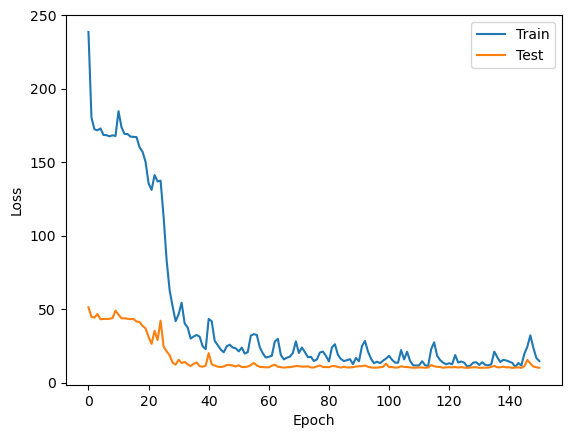

In [ ]:
plt.plot(train_plot, label="Train")
plt.plot(test_plot, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

### FNOv2

In [4]:
class AntennaImageDatasetV2(Dataset): 
    def __init__(self, folder_path): 
        self.label_path = os.path.join(folder_path, 'labels')
        self.input_path = os.path.join(folder_path, 'x')
        self.len = None
        
    def __len__(self): 
        if self.len == None: 
            self.len = 0
            for name in os.listdir(self.label_path):
                if ".npy" in name: 
                    self.len += 1
        return self.len
        
    def __getitem__(self, idx): 
        input_path = os.path.join(self.input_path, 'train_%04d.npy' % idx)
        label_path = os.path.join(self.label_path, 'train_%04d_label.npy' % idx)
        
        sources_img = torch.Tensor(np.load(input_path))[0]
        label_img = torch.Tensor(np.load(label_path))
        
        return sources_img[..., None], label_img[..., None]

/home/winnaries/miniconda3/envs/rebel/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/winnaries/miniconda3/envs/rebel/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


(torch.Size([140, 140, 1]), torch.Size([140, 140, 1]), 2000)

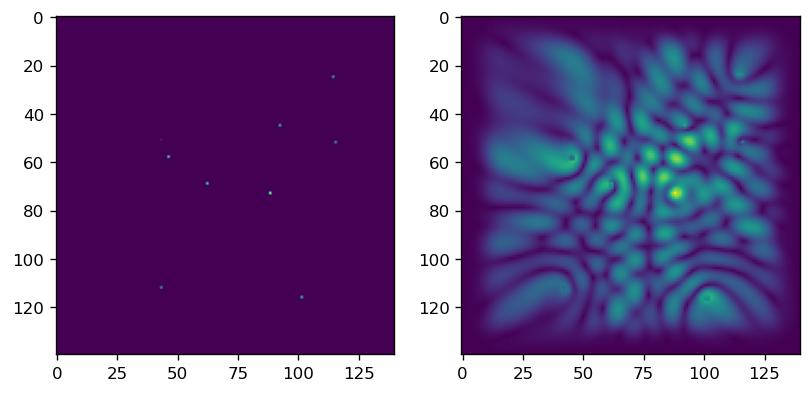

In [5]:
datasets = AntennaImageDatasetV2('./data_v3')
demo_sources, demo_label = datasets[192]

fig, axes = plt.subplots(1, 2, dpi=120, figsize=(8, 8))
axes[0].imshow(demo_sources)
axes[1].imshow(demo_label)

demo_sources.shape, demo_label.shape, len(datasets)

In [6]:
torch.manual_seed(123)
train_datasets, test_datasets = random_split(datasets, [1760, 240])
train_dataloader = DataLoader(train_datasets, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=64, shuffle=True)

In [7]:
class FNO2dV2(nn.Module): 
    def __init__(self, modes1, modes2, width): 
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9
        
        self.p = nn.Linear(3, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4)
        
    def forward(self, sources):        
        grid = self.get_grid(sources.shape, sources.device)
        # phases = self.get_phase_encoding(phases)
        
        x = torch.cat((sources, grid), dim=-1)
        
        x = self.p(x).permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = self.q(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)
    
    def get_phase_encoding(self, phases): 
        return F.one_hot((phases.squeeze(-1) / 90).to(dtype=torch.long), num_classes=4)
        

In [8]:
model = FNO2dV2(16, 16, 32).cuda()
loss_func = LpLoss()

In [ ]:
train_plot = []
test_plot = []
best = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

pbar = range(1000)
for epoch in range(1000): 
    model.train()
    train_loss = 0
    test_loss = 0
    
    pbar = tqdm(enumerate(iter(train_dataloader)), total=len(train_dataloader),
                desc="Train Epoch %d" % epoch, ncols=100)
    for i, (sources, label) in pbar:
        sources = sources.cuda()
        label = label.cuda()
        bsz = sources.shape[0]
        optimizer.zero_grad()
        output = model(sources)
        loss = loss_func(output.view(bsz, -1),
                          label.view(bsz, -1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix({'train_loss': train_loss / (i + 1)})
    
    model.eval()
    with torch.no_grad(): 
        pbar = tqdm(iter(test_dataloader), desc="Test Epoch %d" % epoch, ncols=100)
        for (sources, label) in pbar: 
            bsz = sources.shape[0]
            sources = sources.cuda()
            label = label.cuda()
            output = model(sources)
            loss = loss_func(output.view(bsz, -1),
                              label.view(bsz, -1))
            test_loss += loss.item()
            pbar.set_postfix({'test_loss': test_loss})

    train_plot.append(train_loss)
    test_plot.append(test_loss)
    
    if test_loss < best: 
        best = test_loss
        torch.save(model.state_dict(), "checkpoints/fno2d-v4-best.pt")
    

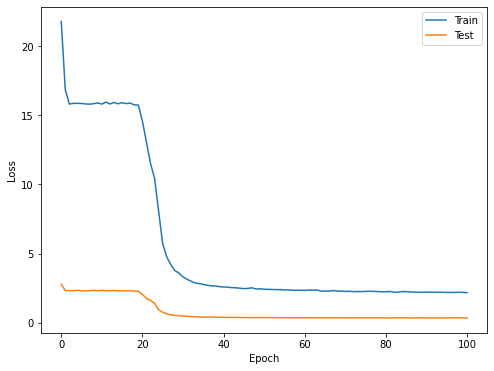

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_plot, label="Train")
ax.plot(test_plot, label="Test")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
None

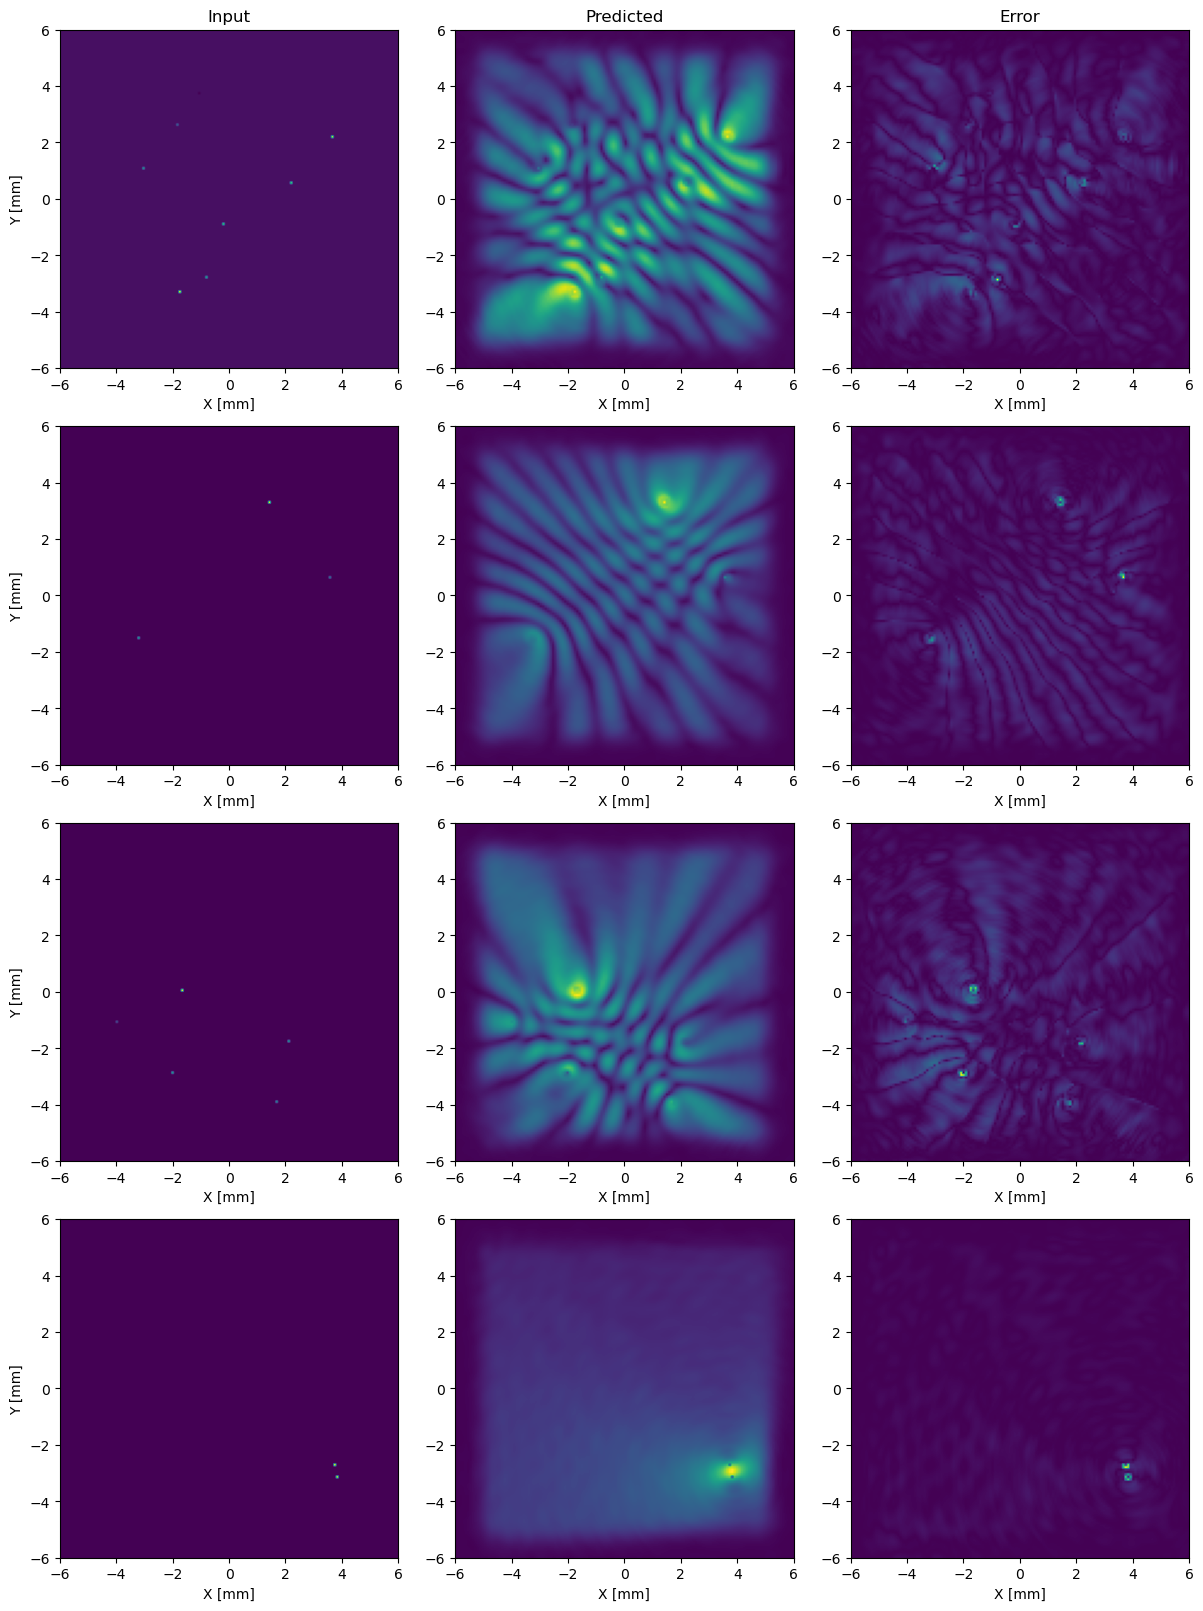

In [25]:
model.load_state_dict(torch.load('checkpoints/fno2d-v3-best.pt'))
length = 4
fig, axes = plt.subplots(length, 3, figsize=(12, 4 * length))
fig.tight_layout(pad=1)
begin = 10

# fno > cnn = 13 (receptive)
# fno > cnn = 199 (complex)

with torch.no_grad(): 
    for i in range(length): 
        demo_sources, demo_label = test_datasets[begin + i]
        demo_y = model(demo_sources.cuda()[None, ...])
        demo_y = demo_y[0]
        
        demo_y = demo_y / demo_y.max()
        demo_label = demo_label / demo_label.max()
        error = demo_y.permute(1, 2, 0).cpu() - demo_label
        
        ext = [-6, 6, -6, 6]
        axes[i, 0].imshow(demo_sources.cpu(), extent=ext)
        axes[i, 1].imshow(demo_y.cpu().permute(1, 2, 0), extent=ext)
        axes[i, 2].imshow(np.abs(error), extent=ext)
        
axes[0, 0].set_title("Input")
axes[0, 1].set_title("Predicted")
axes[0, 2].set_title("Error")

for ax in axes.flatten(): 
    ax.set_xlabel("X [mm]")
    
for i in range(length): 
    axes[i, 0].set_ylabel("Y [mm]")
    
fig.savefig("fno_demo.png", facecolor="white", bbox_inches='tight')

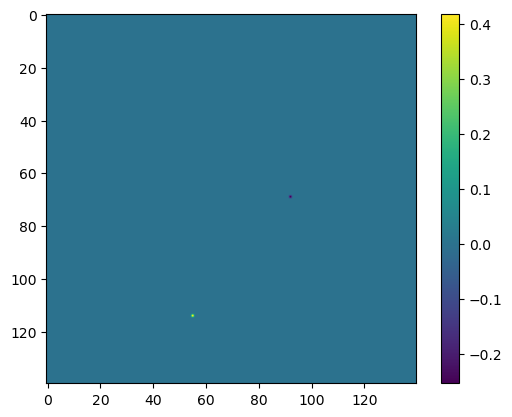

In [28]:
src, label = test_datasets[160]
plt.imshow(src)
plt.colorbar()

### FNOv2 Evaluation

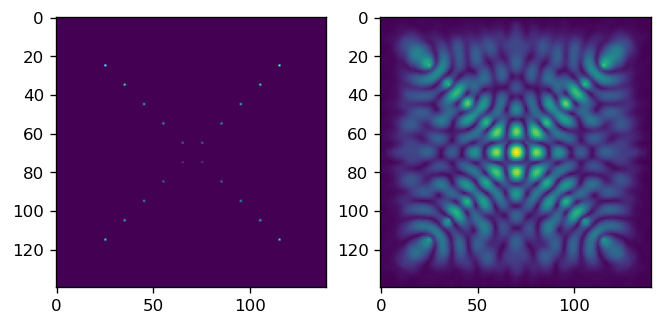

In [43]:
with torch.no_grad(): 
    x = np.zeros((1, 140, 140, 1))
    # x[:, 70, 70] = 5.0
    
    for i in range(10): 
        idx = 25 + i * 10
        x[:, idx, idx] = 0.2 + abs(i - 5) * 0.2
        x[:, idx, 140 - idx] = 0.2 + abs(i - 5) * 0.2
        
    # for i in range(10): 
    #     idx = 115 - i * 10
    #     idx0 = 25 + i * 10
    #     x[: idx0, idx] = 0.2 + abs(i - 5) * 0.2
        
    x = torch.Tensor(x).cuda()
    y = model(x)
    fig, axes = plt.subplots(1, 2, dpi=120)
    axes[0].imshow(x.cpu().squeeze(0))
    axes[1].imshow(y.cpu().squeeze(0).permute(1, 2, 0))

In [ ]:
with torch.no_grad(): 
    x = np.zeros((1, 140, 140, 1))
    x[:, 70, 70] = 5.0
    
    # for i in range(10): 
    #     idx = 25 + i * 10
    #     x[:, idx, idx] = 0.2 + abs(i - 5) * 0.2
        
    x = torch.Tensor(x).cuda()
    y = model(x)
    fig, axes = plt.subplots(1, 2, dpi=120)
    axes[0].imshow(x.cpu().squeeze(0))
    axes[1].imshow(y.cpu().squeeze(0).permute(1, 2, 0))

In [27]:
import time

elapsed = np.zeros(50)
cpu_model = model.cpu()
    
for i in range(50): 
    demo_sources, demo_label = test_datasets[i]
    st = time.time()
    demo_y = cpu_model(demo_sources[None, ...])
    ed = time.time()
    elapsed[i] = ed - st
    

In [28]:
np.mean(elapsed), np.std(elapsed)

(0.030596680641174316, 0.004744327961712363)

In [107]:
from matplotlib import colors

resolution = 10  # pixels/um

sxy = 10
dpml = 2
cell = mp.Vector3(sxy+2*dpml,sxy+2*dpml,0)
pml_layers = [mp.PML(dpml)]

freq = 0.66713 # 200 GHz
geometry = [mp.Block(mp.Vector3(x=mp.inf, y=mp.inf, z=mp.inf),
                     center=mp.Vector3(0, 0, 0),
                     material=mp.Medium(epsilon=1))]
src_cmpt = mp.Ez


def uniform_random_sources(n=None):
    if n is None: n = np.random.randint(2, 4)
    
    points = (sxy * np.random.random(size=(n, 2)) - (sxy/2.0)) * 0.95
    amplitudes = 0.1 + np.random.normal(size=(n), loc=0.9, scale=0.5)
    cent_vec = [mp.Vector3(x=s[0], y=s[1], z=0) for s in points]
    
    sources = [mp.Source(src=mp.ContinuousSource(freq),
                         center=c, component=src_cmpt,
                         amplitude=amp) 
               for amp, c in zip(amplitudes, cent_vec)]
    
    return sources, points, amplitudes

def get_x_img(phasor_arr, points, amps):
    x = np.zeros_like(phasor_arr, dtype=float)
    
    xs = []
    ys = []
    for p in points:
        _fullwidth = 2 * dpml + sxy
        xs.append((x.shape[1]-1)*((p[1]+_fullwidth/2.0)/_fullwidth))
        ys.append((x.shape[0]-1)*((p[0]+_fullwidth/2.0)/_fullwidth))
    xs = np.round(xs).astype(int)
    ys = np.round(ys).astype(int)

    for xp, yp, a in zip(xs, ys, amps):
        x[yp, xp] = a
        
    return x

max_meep_amplitude = 1.0
conversion_norm = colors.Normalize(vmin=0, vmax=max_meep_amplitude*376.7, clip=True)
norm = colors.Normalize(vmin=0, vmax=max_meep_amplitude * 2, clip=True)

-----------
Initializing structure...
time for choose_chunkdivision = 8.39233e-05 s
Working in 2D dimensions.
Computational cell is 14 x 14 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0276952 s
-----------
Meep: using complex fields.
final residual = 8.16284e-09
Finished solve_cw after 227 CG iters (~ 908 timesteps).


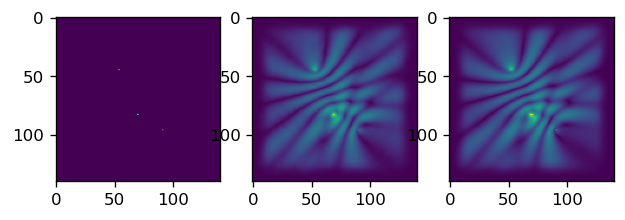

In [121]:
fig, axes = plt.subplots(1, 3, dpi=120)

sources, points, amplitudes = uniform_random_sources()

sim = mp.Simulation(cell_size=cell,
                    resolution=resolution,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    force_complex_fields=True)

sim.init_sim()
sim.solve_cw()

arr = sim.get_array(component=mp.Ez)

x_img = get_x_img(arr, points, amplitudes)

with torch.no_grad(): 
    sources = torch.Tensor(x_img)[None, ..., None]
    pred = cpu_model(sources)

axes[0].imshow(x_img)
axes[1].imshow(pred.squeeze(0).permute(1, 2, 0), norm=norm)
axes[2].imshow(np.abs(arr), norm=norm)